In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# lesson3 Image segmentation

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

## 数据集
1. [SegNet Tutorial](http://mi.eng.cam.ac.uk/projects/segnet/tutorial.html)
2. [alexgkendall/SegNet-Tutorial: Files for a tutorial to train SegNet for road scenes using the CamVid dataset](https://github.com/alexgkendall/SegNet-Tutorial)

In [3]:
# 下载数据集
!git clone git@github.com:alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking connectivity... done.


移动 CamVid 到datasets文件夹

In [4]:
# 设置数据集的路径
path = Path('./datasets/CamVid')

In [5]:
# 查看路径下的文件和文件夹
path.ls()

[PosixPath('datasets/CamVid/trainannot'),
 PosixPath('datasets/CamVid/test'),
 PosixPath('datasets/CamVid/valannot'),
 PosixPath('datasets/CamVid/val.txt'),
 PosixPath('datasets/CamVid/train'),
 PosixPath('datasets/CamVid/train.txt'),
 PosixPath('datasets/CamVid/test.txt'),
 PosixPath('datasets/CamVid/val'),
 PosixPath('datasets/CamVid/testannot')]

## 数据处理

In [6]:
# 验证集的文件名列表
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('datasets/CamVid/val/0016E5_08097.png'),
 PosixPath('datasets/CamVid/val/0016E5_08127.png'),
 PosixPath('datasets/CamVid/val/0016E5_08081.png')]

In [7]:
# 验证集的标签
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('datasets/CamVid/valannot/0016E5_08097.png'),
 PosixPath('datasets/CamVid/valannot/0016E5_08127.png'),
 PosixPath('datasets/CamVid/valannot/0016E5_08081.png')]

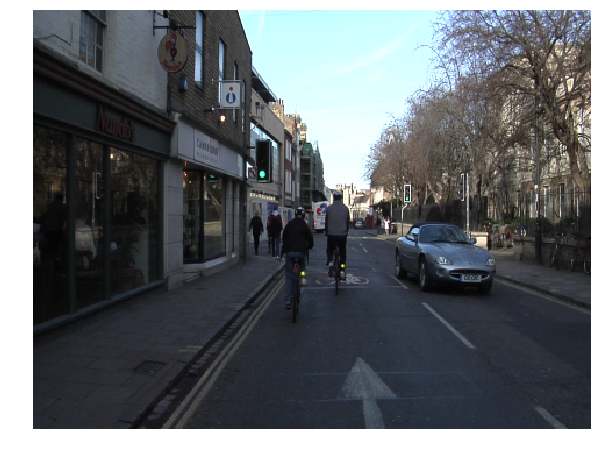

In [37]:
# 随机查看一张图片
img_f = fnames[60]
img = open_image(img_f)
img.show(figsize=(10,10))

In [38]:
img.shape
img.data

torch.Size([3, 360, 480])

tensor([[[0.3569, 0.3608, 0.3647,  ..., 0.6000, 0.5098, 0.7843],
         [0.3294, 0.3412, 0.3569,  ..., 0.7373, 0.6118, 0.5412],
         [0.3294, 0.3294, 0.3412,  ..., 0.5412, 0.5059, 0.7216],
         ...,
         [0.1529, 0.1529, 0.1451,  ..., 0.1490, 0.1373, 0.1373],
         [0.1529, 0.1569, 0.1529,  ..., 0.1529, 0.1490, 0.1490],
         [0.1490, 0.1412, 0.1412,  ..., 0.1373, 0.1490, 0.1412]],

        [[0.3922, 0.3961, 0.4000,  ..., 0.7020, 0.6039, 0.8431],
         [0.3725, 0.3843, 0.4000,  ..., 0.8275, 0.7098, 0.6118],
         [0.3647, 0.3686, 0.3804,  ..., 0.6314, 0.6157, 0.8039],
         ...,
         [0.1686, 0.1686, 0.1608,  ..., 0.1686, 0.1569, 0.1686],
         [0.1686, 0.1725, 0.1686,  ..., 0.1725, 0.1686, 0.1804],
         [0.1647, 0.1569, 0.1569,  ..., 0.1569, 0.1686, 0.1725]],

        [[0.4314, 0.4353, 0.4392,  ..., 0.8314, 0.7922, 1.0000],
         [0.4118, 0.4235, 0.4392,  ..., 0.9529, 0.8902, 0.8196],
         [0.4039, 0.4078, 0.4196,  ..., 0.7608, 0.7412, 0.

In [21]:
# 获取对应标注的文件名
def get_y_fn(x):
    return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [22]:
img_f
img_f.parent  # 父文件夹路径
img_f.name  # 文件名

PosixPath('datasets/CamVid/val/0016E5_08027.png')

PosixPath('datasets/CamVid/val')

'0016E5_08027.png'

In [26]:
doc(open_mask)

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.

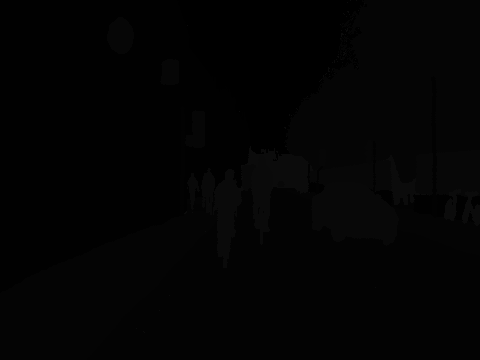

In [32]:
img = open_image(get_y_fn(img_f))
img.data
img

PosixPath('datasets/CamVid/valannot/0016E5_08027.png')

tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]]])

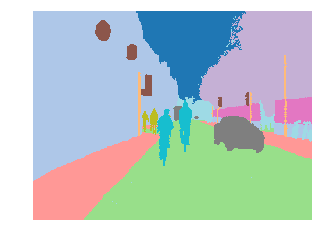

In [33]:
get_y_fn(img_f)
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
mask.data

In [39]:
mask.shape
src_size = np.array(mask.shape[1:])
src_size # 图像的高宽
mask.data

torch.Size([1, 360, 480])

array([360, 480])

tensor([[[1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         [1, 1, 1,  ..., 5, 5, 5],
         ...,
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3],
         [4, 4, 4,  ..., 3, 3, 3]]])

## 创建数据束 